# 資料預處理

In [1]:
import os
os.chdir("C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\Code")
import sys
sys.path.append("C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\Code")

from Get_file import Get_file   # return dirpath, dirnames, filenames
from FFT import FFT, PlotDataOnTimeDomain
from BandPassFilter import BandPassFilter, PlotDataOnFreqDomain, BandPassListFilter
import pyedflib
import numpy as np
import datetime

import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA

%matplotlib inline

data_path = "C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\database"  # EEG Data direction
BandPassICAFigureSavingDirection = "C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\Code\\Fig"
SaveFFTAllDataDirection = "C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\Code\\Fig\\FFTFig_AllData"

# Setting parameters
SampleFrequency = 128
DEBUG = True
LabelSize = 40
LowerFreqCut = 8
HigherFreqCut = 30
BandPassOrder = 3
channel_we_use = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]   # 0~39 共40, 14 channels we use
SAVE_FIG = False

# fix random seed for reproducibility
np.random.seed(7)

### 讀取檔案

In [2]:
#Four Lables
normal_label = []   # 0
scare_label = []    # 1
touch_label = []    # 2
laugh_label = []    # 3

#Four Signal
normal_signal = []
scare_signal = []
touch_signal = []
laugh_signal = []

signal = []
labels = []

_,data_files,_ = Get_file(data_path)
if data_files == []:
    raise("Not found any files ! check your data_path")
else:
    print('Get data from database ...')
    for data in data_files:
        _,_,file_names = Get_file(data_path+'\\'+data)
        for fn in file_names:
            if fn.split('.')[1] == 'edf':
                fedf = pyedflib.EdfReader(data_path+'\\'+data+'\\'+fn)
                n = fedf.signals_in_file
                signal_labels = np.asarray(fedf.getSignalLabels())
                sigbufs = np.zeros((n, fedf.getNSamples()[0]))
                for i in np.arange(n):
                    sigbufs[i, :] = fedf.readSignal(i)

                if 'normal' in fn:
                    normal_label.append(0)
                    normal_signal.append(sigbufs)
                elif 'scare' in fn:
                    scare_label.append(1)
                    scare_signal.append(sigbufs)
                elif 'touch' in fn:
                    touch_label.append(2)
                    touch_signal.append(sigbufs)
                elif 'laugh' in fn:
                    laugh_label.append(3)
                    laugh_signal.append(sigbufs)
                    
                if DEBUG:
                    print(sigbufs.shape)

''' Labels --> 40 channels
['COUNTER' 'INTERPOLATED' 'AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8'
 'T8' 'FC6' 'F4' 'F8' 'AF4' 'RAW_CQ' 'GYROX' 'GYROY' 'MARKER'
 'MARKER_HARDWARE' 'SYNC' 'TIME_STAMP_s' 'TIME_STAMP_ms' 'CQ_AF3' 'CQ_F7'
 'CQ_F3' 'CQ_FC5' 'CQ_T7' 'CQ_P7' 'CQ_O1' 'CQ_O2' 'CQ_P8' 'CQ_T8' 'CQ_FC6'
 'CQ_F4' 'CQ_F8' 'CQ_AF4' 'CQ_CMS' 'CQ_DRL']
'''

print('Okay')
if DEBUG:
    print('normal signal length : ', len(normal_signal))
    print('scare signal length : ', len(scare_signal))
    print('touch signal length : ', len(touch_signal))
    print('laugh signal length : ', len(laugh_signal))


Get data from database ...
(40, 38400)
(40, 105344)
(40, 38400)
(40, 105344)
(40, 179328)
(40, 309760)
(40, 38400)
(40, 105728)
(40, 158976)
(40, 58112)
(40, 50944)
(40, 33152)
(40, 3968)
(40, 38400)
(40, 105344)
(40, 178944)
(40, 308992)
(40, 38400)
(40, 105728)
(40, 179840)
(40, 237312)
(40, 38400)
(40, 105600)
(40, 179584)
(40, 38400)
(40, 178944)
(40, 308864)
(40, 38400)
(40, 105344)
(40, 179072)
(40, 83328)
(40, 117632)
(40, 107392)
(40, 38400)
(40, 308992)
(40, 38400)
(40, 179072)
(40, 105344)
(40, 308736)
(40, 38400)
(40, 313472)
(40, 38400)
(40, 105344)
(40, 38400)
(40, 105344)
(40, 38528)
(40, 179200)
(40, 308736)
(40, 38400)
(40, 179328)
(40, 38400)
(40, 105344)
Okay
normal signal length :  16
scare signal length :  11
touch signal length :  9
laugh signal length :  16


In [3]:
def GrabEmotion(Signal, TimeSecondsi, TimeSecondsf):
    pass

In [4]:
def CheckListTheSameSize(ListData):
    di = 0
    dsum = 0
    for i in range(len(ListData)):
        if i == 0:
            pass
        else:
            dsum += (ListData[i].shape == ListData[i-1].shape)
            
    if np.sum(dsum) != (len(ListData)-1):
        return False
    else:
        return True
    
def CalculateZeros(NumpyArray):
    LogicWithZeros = (NumpyArray == 0)
    return np.sum(LogicWithZeros)

def PlotFreqencyFigure(FreqList, FFTData, FreqL, FreqH, YlimL=None, YlimH=None, title=None, FigSize=(12,8)):
    plt.figure(figsize=FigSize)
    plt.plot(FreqList, FFTData, '*-')
    plt.xlabel('Freq(Hz)')
    plt.ylabel('micro volt (mv)')
    plt.xlim(FreqL, FreqH)
    if YlimL is None and YlimH is None:
        pass
    else:
        plt.ylim(YlimL, YlimH)
    if title is not None:
        plt.title(title)
        
    else:
        plt.title('FreqencyFigure')
    plt.grid(True)
    plt.show()

### Analyze steps : Filters ==> FFT ==> Build Model

In [5]:
# Filter, Each Data 128*5 second to as a period
# Return Data Shape : [(TimestepsData, Features)]  --> List, each list data is one channel's data Split numbers
def BandPassSPlitOneChannelData(SignalListData, LowerFreqCut, HigherFreq, channel, fs, order=5, PlotFlag=False):
    channel_we_use = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]   # 0~39 共40, 14 channels we use
    SamplesPerSecond = fs
    DataLength = SignalListData[0].shape[1]
    SignalFreqX = 0
    ReturnSignalList = []
    for i in range(len(SignalListData)):
        LabelNum = SignalListData[i].shape[0]
        FeaturesNum = SignalListData[i].shape[1]
        TimesToSplit = int(FeaturesNum/SamplesPerSecond)
        print('Features Numbers : ', FeaturesNum)
        print('Times to Split Numbers :', TimesToSplit)
        CHCNT = 0
        for ch in range(LabelNum):
            if ch == channel_we_use[channel]:   # Run one time
                SignalData = np.zeros([5, 23], dtype=np.float32)
                Times = 0
                FiveTimesToSplitBuff = np.zeros([5, 64], dtype=np.float32)   # Five Seconds Data Buffer
                FiveSecondCNT = 0
                TimestepCNT = 0
                for t in range(TimesToSplit):
                    ChannelData = BandPassFilter(SignalListData[i][ch][Times:Times+SamplesPerSecond],
                                                         LowerFreqCut, HigherFreqCut, fs, order=order)
                    SignalFreqX, FFTChannelData = FFT(ChannelData, SampleFrequency, data_length=128)
                    Times += SamplesPerSecond
                    FiveTimesToSplitBuff[FiveSecondCNT, :] = FFTChannelData
                    FiveSecondCNT += 1
                    if FiveSecondCNT > 4:
                        SignalData = FiveTimesToSplitBuff
                        FiveTimesToSplitBuff = np.zeros([5, 64], dtype=np.float32)   # Five Seconds Data Buffer
                        FiveSecondCNT = 0
                        if CalculateZeros(SignalData) != 0:
                            print("Warning: Have Zero Values in the Numpy array !!!")
                        ReturnSignalList.append(SignalData)
                        
                    if PlotFlag:
                        if t % 10 == 0:
                            PlotFreqencyFigure(SignalFreqX, FFTChannelData, 8, 30)

                TimestepCNT = 0
                CHCNT += 1


    return SignalFreqX, ReturnSignalList

In [21]:
# Return data is a list type
# Each list data is a array type which shape is (Channels, TimesSplit, Features)
# Warning TimeSpilt maybe not the same, so I use list to save the data
SignalFreqX, NormalSignalList = BandPassSPlitOneChannelData(normal_signal, LowerFreqCut, HigherFreqCut, 8, SampleFrequency, order=BandPassOrder, PlotFlag=False)
SignalFreqX, ScareSignalList = BandPassSPlitOneChannelData(scare_signal, LowerFreqCut, HigherFreqCut, 8, SampleFrequency, order=BandPassOrder, PlotFlag=False)
SignalFreqX, TouchSignalList = BandPassSPlitOneChannelData(touch_signal, LowerFreqCut, HigherFreqCut, 8, SampleFrequency, order=BandPassOrder, PlotFlag=False)
SignalFreqX, LaughSignalList = BandPassSPlitOneChannelData(laugh_signal, LowerFreqCut, HigherFreqCut, 8, SampleFrequency, order=BandPassOrder, PlotFlag=False)

if DEBUG:
    # Signal Data Numbers
    print('Normal Data length:', len(NormalSignalList))
    print('Scare Data lentgh:', len(ScareSignalList))
    print('Touch Data length:', len(TouchSignalList))
    print('Laugh Data length:', len(LaughSignalList))
    

Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38528
Times to Split Numbers : 301
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  38400
Times to Split Numbers : 300
Features Numbers :  105344
Times to Split Numbers : 823
Features Numbers :  105344
Times to Split Numbers : 823
Features

In [22]:
def ListToArray(SignalListData):
    ListLength = len(SignalListData)
    TimeSteps = 5
    FeaturesNum = 64
    SignalArray = np.zeros([ListLength, TimeSteps, FeaturesNum], dtype=np.float32)
    for i in range(ListLength):
        SignalArray[i,:,:] = SignalListData[i]
    if CalculateZeros(SignalArray) != 0:
        print("Warning: Have Zero Values in the Numpy array !!!")
    return SignalArray

In [23]:
NormalSignalArray = ListToArray(NormalSignalList)
ScareSignalArray = ListToArray(ScareSignalList)
TouchSignalArray = ListToArray(TouchSignalList)
LaughSignalArray = ListToArray(LaughSignalList)

if DEBUG:
    # Signal Data Numbers
    print('Normal Array length:', NormalSignalArray.shape)
    print('Scare Array lentgh:', ScareSignalArray.shape)
    print('Touch Array length:', TouchSignalArray.shape)
    print('Laugh Array length:', LaughSignalArray.shape)

Normal Array length: (960, 5, 64)
Scare Array lentgh: (1807, 5, 64)
Touch Array length: (2517, 5, 64)
Laugh Array length: (4707, 5, 64)


### Build the Training Data

In [24]:
X = np.vstack((NormalSignalArray,\
               ScareSignalArray,\
               TouchSignalArray,\
               LaughSignalArray))
Normaly = np.ones([NormalSignalArray.shape[0]], dtype=np.float32) * 1
Scarey = np.ones([ScareSignalArray.shape[0]], dtype=np.float32) * 2
Touchy = np.ones([TouchSignalArray.shape[0]], dtype=np.float32) * 3
Laughy = np.ones([LaughSignalArray.shape[0]], dtype=np.float32) * 4
y = np.hstack((Normaly,\
              Scarey,\
              Touchy,\
              Laughy))
print('X Shape : ', X.shape)
print('y Shape : ', y.shape)

X Shape :  (9991, 5, 64)
y Shape :  (9991,)


In [25]:
# Hyper parameter Setup
TEST_SIZE = 0.3
BATCH_SIZE = 128        # betch training per 128 as a batch
TIME_STEP = 5   # per five seconds
INPUT_SIZE = 64    # 64 Features
LEARNING_RATE = 0.01


In [26]:
# Normalize and to Split the training data, testing data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

OneHot = OneHotEncoder()
OneHot_y = OneHot.fit_transform(y.reshape(-1,1)).toarray()

def Split_data(raw_X, raw_y, test_size, Standard=True):
    train_X, test_X, train_y, test_y = train_test_split(raw_X, raw_y, test_size=test_size, shuffle=True)
    if Standard:
        sc = StandardScaler()
        sc.fit(train_X)
        train_X = sc.transform(train_X)
        test_X = sc.transform(test_X)
    self.X = train_X
    self.y = train_y
    return train_X, test_X, train_y, test_y

train_X, test_X, train_y, test_y = train_test_split(X, OneHot_y , test_size=TEST_SIZE)
std = StandardScaler()



if DEBUG:
    print('Train X Shape : ', train_X.shape)
    print('Train y shape : ', train_y.shape)
    print('Test X Shape : ', test_X.shape)
    print('Test y shape : ', test_y.shape)

Train X Shape :  (6993, 5, 64)
Train y shape :  (6993, 4)
Test X Shape :  (2998, 5, 64)
Test y shape :  (2998, 4)


# Build LSTM RNN Model

In [27]:
# import LSTM Package using keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import SimpleRNN, LSTM
import keras.backend as K
from keras import metrics

In [28]:
# RNN/LSTM: input format (batch_size, timesteps, input_dim)
model = Sequential()
model.add(LSTM(units=20, input_shape=(TIME_STEP, INPUT_SIZE)))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy])

In [29]:
# See the NN Configure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                6800      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               10500     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 404       
Total params: 67,804
Trainable params: 67,804
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Training Data now
model.fit(train_X, train_y, epochs=20, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/20
 - 2s - loss: 1.2507 - categorical_accuracy: 0.4665
Epoch 2/20
 - 1s - loss: 1.2430 - categorical_accuracy: 0.4692
Epoch 3/20
 - 1s - loss: 1.2423 - categorical_accuracy: 0.4692
Epoch 4/20
 - 1s - loss: 1.2412 - categorical_accuracy: 0.4692
Epoch 5/20
 - 1s - loss: 1.2413 - categorical_accuracy: 0.4692
Epoch 6/20
 - 1s - loss: 1.2421 - categorical_accuracy: 0.4692
Epoch 7/20
 - 1s - loss: 1.2414 - categorical_accuracy: 0.4692
Epoch 8/20
 - 1s - loss: 1.2406 - categorical_accuracy: 0.4693
Epoch 9/20
 - 1s - loss: 1.2403 - categorical_accuracy: 0.4693
Epoch 10/20
 - 1s - loss: 1.2409 - categorical_accuracy: 0.4693
Epoch 11/20
 - 1s - loss: 1.2405 - categorical_accuracy: 0.4692
Epoch 12/20
 - 1s - loss: 1.2412 - categorical_accuracy: 0.4692
Epoch 13/20
 - 1s - loss: 1.2401 - categorical_accuracy: 0.4693
Epoch 14/20
 - 1s - loss: 1.2414 - categorical_accuracy: 0.4693
Epoch 15/20
 - 1s - loss: 1.2405 - categorical_accuracy: 0.4693
Epoch 16/20
 - 1s - loss: 1.2405 - categorical_ac

In [31]:
# Calculate the accuracy
TrainScore = model.evaluate(train_X, train_y, batch_size=BATCH_SIZE)[1]
TestScore = model.evaluate(test_X, test_y, batch_size=BATCH_SIZE)[1]
print('Training data accuracy : ', TrainScore*100)
print('Testing data accuracy : ', TestScore*100)

2998/2998 [==============================] - 0s 41us/step
Training data accuracy :  46.9326469364825
Testing data accuracy :  47.5650433880874


In [32]:
# Predict Train data
TrainPredict = model.predict(train_X)
print(TrainPredict)

[[0.08967625 0.17329045 0.24616702 0.49086627]
 [0.08967625 0.17329045 0.24616702 0.49086627]
 [0.08967625 0.17329045 0.24616702 0.49086627]
 ...
 [0.08967625 0.17329045 0.24616702 0.49086627]
 [0.08967625 0.17329045 0.24616702 0.49086627]
 [0.08967625 0.17329045 0.24616702 0.49086627]]


In [33]:
TestPredict = model.predict(test_X)
print(TestPredict)

[[0.08967625 0.17329045 0.24616702 0.49086627]
 [0.08967625 0.17329045 0.24616702 0.49086627]
 [0.08967625 0.17329045 0.24616702 0.49086627]
 ...
 [0.08967625 0.17329045 0.24616702 0.49086627]
 [0.08967625 0.17329045 0.24616702 0.49086627]
 [0.08967625 0.17329045 0.24616702 0.49086627]]


In [34]:
train_X.shape

(6993, 5, 64)

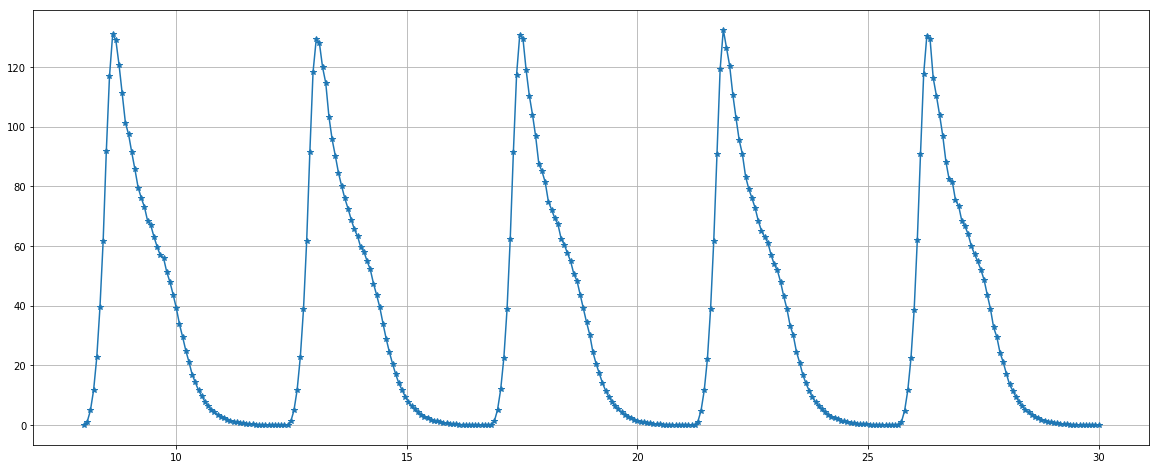

In [35]:
a = train_X[3,:,:].reshape(5*64)
b = np.linspace(8,30,a.shape[0])
plt.figure(figsize=(20,8))
plt.plot(b,a,'*-')
plt.grid(True)
plt.show()